In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

wildfires_df = pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/wildfires.csv', delimiter=',')

# Load wildfire data into a GeoDataFrame
gdf_wildfires = gpd.GeoDataFrame(
    wildfires_df,
    geometry=wildfires_df.apply(lambda row: Point(row['attr_InitialLongitude'], row['attr_InitialLatitude']), axis=1),
    crs="EPSG:4326"
)

# Load the California shapefile
gdf_california = gpd.read_file('/content/drive/MyDrive/CS249-Winter2024-Project/ca_state_boundary/ca_state_boundaries.shp')

# Use spatial join to filter wildfires within California's boundary
california_wildfires_gdf = gpd.sjoin(gdf_wildfires, gdf_california, how="inner", op='intersects')
california_wildfires_gdf['poly_CreateDate'] = pd.to_datetime(california_wildfires_gdf['poly_CreateDate'], format='%m/%d/%Y %I:%M:%S %p')

california_wildfires_gdf.iloc[:3]

<ipython-input-2-f348983e7fef>:5: DtypeWarning: Columns (46,76) have mixed types. Specify dtype option on import or set low_memory=False.
  wildfires_df = pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/wildfires.csv', delimiter=',')
/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-2-f348983e7fef>:18: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:3857

  california_wildfires_gdf = gpd.sjoin(gdf_wildfires, gdf_california, how="inner", op='intersects')


,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area
46,85,NaN,LINDELL RD / EL TORO RD,Wildfire Daily Fire Perimeter,Hand Sketch,0.01,2022-05-15 02:46:47,5/15/2022 8:15:27 PM,5/15/2022 7:46:15 AM,{372AA56F-5803-4095-9226-CB1A471ED42E},...,California,00,G4000,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192
65,106,6100.0,INKOPAH,Wildfire Daily Fire Perimeter,Auto-generated,0.10,2021-05-04 22:51:24,5/4/2021 10:51:24 PM,1/16/2021 3:11:39 AM,{6D7B9AF9-250F-4866-9FDC-4E2C5471B3C2},...,California,00,G4000,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192
76,119,NaN,LAC-194142,Wildfire Daily Fire Perimeter,Hand Sketch,NaN,2021-05-07 04:52:25,5/7/2021 4:52:25 AM,5/7/2021 4:52:24 AM,{16D3EDA1-AAC8-4902-9B67-D81D4856A8EF},...,California,00,G4000,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192


In [ ]:
stations_df = pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/california_stations.csv', delimiter=',')
stations_df.iloc[:3]

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN_FLAG,HCN_CRN_FLAG,WMO_ID
0,US1CAAL0001,37.8123,-122.2160,113.4,CA,PIEDMONT 1.0 SE,NaN,NaN,NaN
1,US1CAAL0002,37.7075,-122.0687,87.5,CA,CASTRO VALLEY 0.5 WSW,NaN,NaN,NaN
2,US1CAAL0003,37.7169,-122.0585,163.4,CA,CASTRO VALLEY 0.4 NNE,NaN,NaN,NaN


In [ ]:
california_wildfires_gdf['lat'] = pd.to_numeric(california_wildfires_gdf['attr_InitialLatitude'])
california_wildfires_gdf['lon'] = pd.to_numeric(california_wildfires_gdf['attr_InitialLongitude'])
stations_df['lat'] = pd.to_numeric(stations_df['LATITUDE'])
stations_df['lon'] = pd.to_numeric(stations_df['LONGITUDE'])


In [ ]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def find_closest_station(wildfire_row, stations_df):
    distances = stations_df.apply(
        lambda row: haversine(wildfire_row['lon'], wildfire_row['lat'], row['lon'], row['lat']),
        axis=1)
    return stations_df.loc[distances.idxmin()]

# Example: Find the closest station for the first wildfire
closest_station = find_closest_station(california_wildfires_gdf.iloc[0], stations_df)
print(closest_station)


ID              USC00042805
LATITUDE            33.6861
LONGITUDE         -117.3458
ELEVATION             386.5
STATE                    CA
NAME               ELSINORE
GSN_FLAG                NaN
HCN_CRN_FLAG            NaN
WMO_ID                  NaN
lat                 33.6861
lon               -117.3458
Name: 1714, dtype: object


In [ ]:
# Assuming 'ID' is the unique identifier for stations
stations_df.reset_index(inplace=True)
stations_df.rename(columns={'index': 'station_index'}, inplace=True)


In [ ]:
from scipy.spatial import cKDTree

# Prepare the data
station_points = np.deg2rad(stations_df[['LATITUDE', 'LONGITUDE']].values)
wildfire_points = np.deg2rad(california_wildfires_gdf[['attr_InitialLatitude', 'attr_InitialLongitude']].values)

# Build the KDTree and query it for the closest station to each wildfire
tree = cKDTree(station_points)
distances, indices = tree.query(wildfire_points)

# Store the index (or ID) of the closest station
california_wildfires_gdf['closest_station_index'] = indices
california_wildfires_gdf.iloc[:5]

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,lat,lon,closest_station_index
46,85,NaN,LINDELL RD / EL TORO RD,Wildfire Daily Fire Perimeter,Hand Sketch,0.010000,2022-05-15 02:46:47,5/15/2022 8:15:27 PM,5/15/2022 7:46:15 AM,{372AA56F-5803-4095-9226-CB1A471ED42E},...,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192,33.730003,-117.330945,1714
65,106,6100.0,INKOPAH,Wildfire Daily Fire Perimeter,Auto-generated,0.100000,2021-05-04 22:51:24,5/4/2021 10:51:24 PM,1/16/2021 3:11:39 AM,{6D7B9AF9-250F-4866-9FDC-4E2C5471B3C2},...,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192,32.637513,-116.113672,862
76,119,NaN,LAC-194142,Wildfire Daily Fire Perimeter,Hand Sketch,NaN,2021-05-07 04:52:25,5/7/2021 4:52:25 AM,5/7/2021 4:52:24 AM,{16D3EDA1-AAC8-4902-9B67-D81D4856A8EF},...,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192,34.101870,-118.659980,307
82,126,4240.0,"Butte, Tehama, Glenn Lightning Complex",Wildfire Daily Fire Perimeter,Mixed Methods,93.755645,2021-05-04 22:51:16,5/4/2021 10:51:16 PM,NaN,{CC8C44ED-C180-4AE1-BA8C-B6387C32C1B4},...,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192,39.964000,-121.511117,2539
92,136,NaN,EMERALD 2,Wildfire Daily Fire Perimeter,Hand Sketch,NaN,2022-03-16 22:27:26,3/27/2022 10:40:10 PM,NaN,{78A663FA-614B-4A69-861F-9D7EC57DBACA},...,A,4.036733e+11,2.029177e+10,+37.1551773,-119.5434183,42.617368,43.083192,34.091160,-117.094500,2328


In [ ]:
# Merge to add station details to wildfires_df
# Ensure to use the appropriate column name ('ID', 'station_index', etc.) that identifies the station uniquely
wildfires_df = pd.merge(california_wildfires_gdf, stations_df, left_on='closest_station_index', right_on='station_index', suffixes=('_wildfire', '_station'))
wildfires_df.iloc[:5]

# Now wildfires_df contains details from the closest weather station alongside the wildfire details


,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME_station,GSN_FLAG,HCN_CRN_FLAG,WMO_ID,lat_station,lon_station
0,85,NaN,LINDELL RD / EL TORO RD,Wildfire Daily Fire Perimeter,Hand Sketch,0.01,2022-05-15 02:46:47,5/15/2022 8:15:27 PM,5/15/2022 7:46:15 AM,{372AA56F-5803-4095-9226-CB1A471ED42E},...,33.6861,-117.3458,386.5,CA,ELSINORE,NaN,NaN,NaN,33.6861,-117.3458
1,3630,NaN,ROBERT ST LELS,Wildfire Daily Fire Perimeter,GPS-Walked,0.01,2022-07-09 19:52:32,7/10/2022 1:46:52 AM,7/10/2022 12:52:06 AM,{E83DD181-BD2E-4C00-9C92-1FFC31ACD27C},...,33.6861,-117.3458,386.5,CA,ELSINORE,NaN,NaN,NaN,33.6861,-117.3458
2,5655,6723.0,ROBERT ST LELS,Wildfire Final Fire Perimeter,GPS-Walked,0.01,NaT,3/14/2023 3:13:42 PM,11/1/2022 5:36:27 PM,{708C2923-E3B9-4101-A1A7-537DD72C074F},...,33.6861,-117.3458,386.5,CA,ELSINORE,NaN,NaN,NaN,33.6861,-117.3458
3,19440,31670.0,CHIPPEWA,Wildfire Daily Fire Perimeter,Hand Sketch,0.01,2023-08-12 23:21:03,8/13/2023 9:56:30 PM,8/13/2023 3:45:41 AM,{E2EB1E41-8B41-4C13-BBCE-5FDAEA3201D5},...,33.6861,-117.3458,386.5,CA,ELSINORE,NaN,NaN,NaN,33.6861,-117.3458
4,106,6100.0,INKOPAH,Wildfire Daily Fire Perimeter,Auto-generated,0.10,2021-05-04 22:51:24,5/4/2021 10:51:24 PM,1/16/2021 3:11:39 AM,{6D7B9AF9-250F-4866-9FDC-4E2C5471B3C2},...,32.6212,-116.1902,859.8,CA,JACUMBA 0.3 NNW,NaN,NaN,NaN,32.6212,-116.1902


In [42]:
file_paths = ['weather_2020_clean.csv', 'weather_2021_clean.csv', 'weather_2022_clean.csv', 'weather_2023_clean.csv', 'weather_2024_clean.csv']

weather_df = [pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/'+file, delimiter=',') for file in file_paths]

combined_weather_df = pd.concat(weather_df, ignore_index=True)
elements_to_keep = ['PRCP', 'TMAX', 'TMIN', 'TAVG', 'AWND', 'RHAV', 'RHMN', 'RHMX']


filtered_weather_df = combined_weather_df[combined_weather_df['ELEMENT'].isin(elements_to_keep)]
filtered_weather_df['YEAR/MONTH/DAY'] = pd.to_datetime(filtered_weather_df['YEAR/MONTH/DAY'], format='%Y%m%d')
filtered_weather_df['Timestamp'] = filtered_weather_df['YEAR/MONTH/DAY'] + pd.Timedelta(hours=12)

filtered_weather_df['DATA VALUE'] = pd.to_numeric(filtered_weather_df['DATA VALUE'], errors='coerce')
filtered_weather_df['ID'] = filtered_weather_df['ID'].astype(str)
filtered_weather_df['ELEMENT'] = filtered_weather_df['ELEMENT'].astype(str)

pivoted_weather_df = filtered_weather_df.pivot_table(index=['ID', 'Timestamp'],
                                    columns='ELEMENT',
                                    values='DATA VALUE',
                                    aggfunc='mean').reset_index()

pivoted_weather_df.iloc[:3]



<ipython-input-42-eaec4384711e>:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = [pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/'+file, delimiter=',') for file in file_paths]
<ipython-input-42-eaec4384711e>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_df = [pd.read_csv('/content/drive/MyDrive/CS249-Winter2024-Project/'+file, delimiter=',') for file in file_paths]
<ipython-input-42-eaec4384711e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_weather_df['YEAR/MONTH/DAY'] = pd.to_datetime(filtered_weather_df['YEAR/MONTH/DAY'], format='%Y%m%d')
<ipython-input-42-eaec4384711e>:12: Setting

ELEMENT,ID,Timestamp,AWND,PRCP,RHAV,RHMN,RHMX,TAVG,TMAX,TMIN
0,US1CAAL0001,2020-01-01 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,US1CAAL0001,2020-01-02 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,US1CAAL0001,2020-01-03 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Convert wildfire discovery and out dates to datetime
wildfires_df['attr_FireDiscoveryDateTime'] = pd.to_datetime(wildfires_df['attr_FireDiscoveryDateTime'])
wildfires_df['attr_FireOutDateTime'] = pd.to_datetime(wildfires_df['attr_FireOutDateTime'])

# Normalize times to midday (12 PM) for comparison with weather data
# Or you can simply strip the time if exact hour comparison is not required
wildfires_df['Discovery_Date'] = wildfires_df['attr_FireDiscoveryDateTime'].dt.normalize() + pd.Timedelta(hours=12)
wildfires_df['Out_Date'] = wildfires_df['attr_FireOutDateTime'].dt.normalize() + pd.Timedelta(hours=12)

print(list(wildfires_df.columns))


['OBJECTID', 'poly_SourceOID', 'poly_IncidentName', 'poly_FeatureCategory', 'poly_MapMethod', 'poly_GISAcres', 'poly_CreateDate', 'poly_DateCurrent', 'poly_PolygonDateTime', 'poly_IRWINID', 'poly_FORID', 'poly_Acres_AutoCalc', 'poly_SourceGlobalID', 'poly_Source', 'attr_SourceOID', 'attr_ABCDMisc', 'attr_ADSPermissionState', 'attr_CalculatedAcres', 'attr_ContainmentDateTime', 'attr_ControlDateTime', 'attr_CreatedBySystem', 'attr_IncidentSize', 'attr_DiscoveryAcres', 'attr_DispatchCenterID', 'attr_EstimatedCostToDate', 'attr_FinalAcres', 'attr_FFReportApprovedByTitle', 'attr_FFReportApprovedByUnit', 'attr_FFReportApprovedDate', 'attr_FireBehaviorGeneral', 'attr_FireBehaviorGeneral1', 'attr_FireBehaviorGeneral2', 'attr_FireBehaviorGeneral3', 'attr_FireCause', 'attr_FireCauseGeneral', 'attr_FireCauseSpecific', 'attr_FireCode', 'attr_FireDepartmentID', 'attr_FireDiscoveryDateTime', 'attr_FireMgmtComplexity', 'attr_FireOutDateTime', 'attr_FireStrategyConfinePercent', 'attr_FireStrategyFullS

In [45]:
def filter_weather_for_wildfire(row):
    return pivoted_weather_df[(pivoted_weather_df['ID'] == row['ID'])&
     (pivoted_weather_df['Timestamp'] >= row['Discovery_Date']) &
                      (pivoted_weather_df['Timestamp'] <= row['Out_Date'])
                               ]

# Use apply() to filter weather for each wildfire
# Note: This creates a Series of DataFrames
filtered_weather_series = wildfires_df.apply(filter_weather_for_wildfire, axis=1)

# Convert the Series of DataFrames into a single DataFrame
pivoted_weather_df = pd.concat(filtered_weather_series.tolist(), ignore_index=True)


In [47]:
print(len(pivoted_weather_df))
pivoted_weather_df.iloc[:5]

17783


ELEMENT,ID,Timestamp,AWND,PRCP,RHAV,RHMN,RHMX,TAVG,TMAX,TMIN
0,USC00042805,2022-07-09 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,372.0,156.0
1,USC00042805,2022-07-10 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,383.0,167.0
2,USC00042805,2022-07-11 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,356.0,172.0
3,US1CASD0117,2022-07-04 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,US1CASD0117,2022-07-05 12:00:00,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='ELEMENT', ylabel='ELEMENT'>

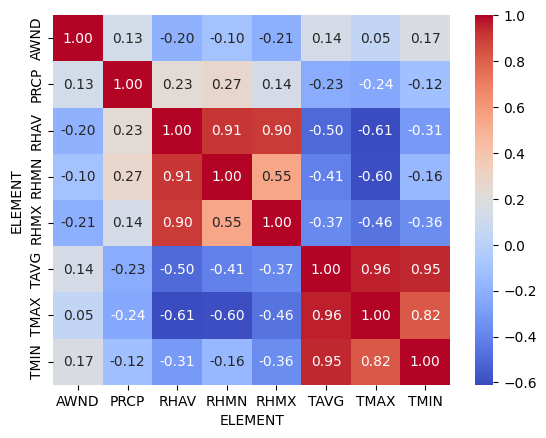

In [48]:
import seaborn as sns

# Compute correlation matrix
corr_matrix = pivoted_df[['AWND', 'PRCP', 'RHAV', 'RHMN', 'RHMX', 'TAVG', 'TMAX', 'TMIN']].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")


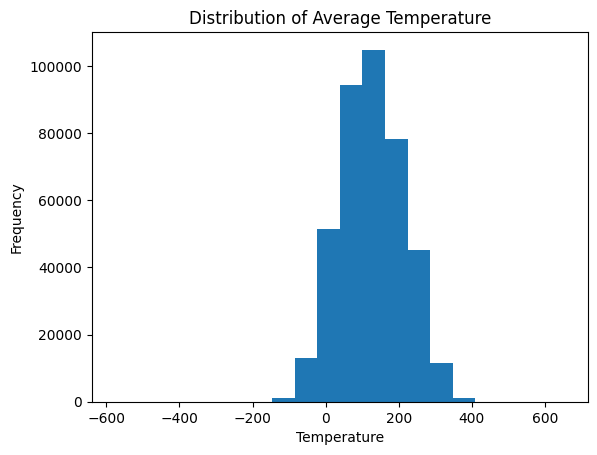

In [49]:
import matplotlib.pyplot as plt

# Histogram of average temperature
pivoted_df['TAVG'].plot.hist(bins=20, title='Distribution of Average Temperature')
plt.xlabel('Temperature')
plt.show()


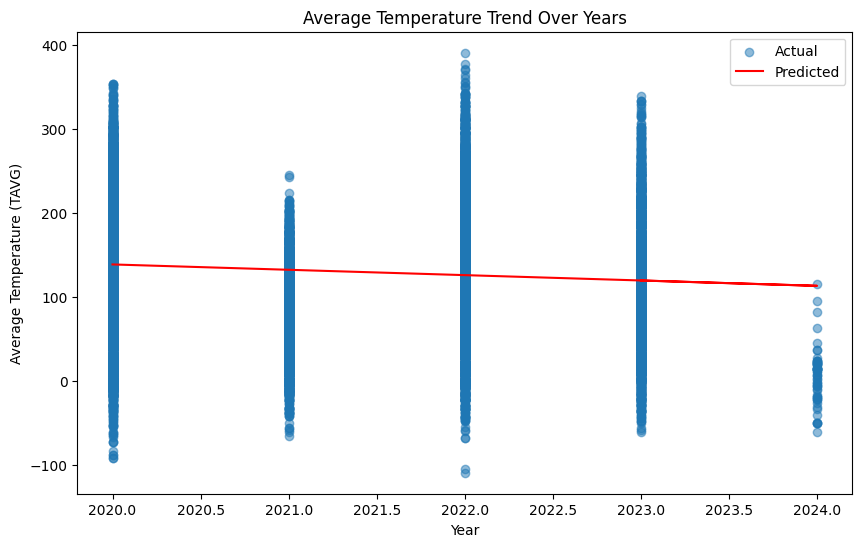

Slope (Temperature change per year): -6.367904685515213


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'DATE' is a datetime type and extract the year for simplicity
pivoted_weather_df['Timestamp'] = pd.to_datetime(pivoted_weather_df['Timestamp'])
pivoted_weather_df['YEAR'] = pivoted_weather_df['Timestamp'].dt.year

# Prepare data for regression model
X = pivoted_weather_df[['YEAR']]  # Predictor variable
y = all_filtered_weather['DATA VALUE']  # Response variable

# Initialize and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict and plot
all_filtered_weather['TAVG_PRED'] = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(all_filtered_weather['YEAR'], all_filtered_weather['DATA VALUE'], alpha=0.5, label='Actual')
plt.plot(all_filtered_weather['YEAR'], all_filtered_weather['TAVG_PRED'], color='red', label='Predicted')
plt.title('Average Temperature Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature (TAVG)')
plt.legend()
plt.show()

print("Slope (Temperature change per year):", model.coef_[0])


In [29]:
rhav_data = all_filtered_weather[all_filtered_weather['ELEMENT'] == 'RHAV']
# Categorize by month for example purposes
rhav_data['Period'] = 'Wet'
rhav_data.loc[rhav_data['Timestamp'].dt.month.isin([5, 6, 7, 8]), 'Period'] = 'Dry'
rhav_data['Timestamp'] = pd.to_datetime(rhav_data['Timestamp'])
from scipy.stats import ttest_ind

# Separate the data into two groups
dry_rhav_values = rhav_data[rhav_data['Period'] == 'Dry']['DATA VALUE']
wet_rhav_values = rhav_data[rhav_data['Period'] == 'Wet']['DATA VALUE']

# Perform a t-test between the two groups
t_stat, p_value = ttest_ind(dry_rhav_values.dropna(), wet_rhav_values.dropna())

print(f"T-statistic: {t_stat}, P-value: {p_value}")
rhav_data['DATA VALUE'] = pd.to_numeric(rhav_data['DATA VALUE'], errors='coerce')


T-statistic: -1.0025157980277688, P-value: 0.3219748132887588


<ipython-input-29-b99c5ca45f64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhav_data['Period'] = 'Wet'
<ipython-input-29-b99c5ca45f64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rhav_data['Timestamp'] = pd.to_datetime(rhav_data['Timestamp'])
<ipython-input-29-b99c5ca45f64>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Interpretation:
T-statistic: This value indicates the direction and magnitude of the difference between the means of your two groups (dry and wet periods, in this case). A negative value suggests that the mean relative humidity (RHAV) during the dry period is lower than during the wet period. However, the magnitude of this difference is relatively small given the value of the statistic.

P-value: The P-value measures the probability of observing a result as extreme as the one you obtained if the null hypothesis were true. The null hypothesis, in this context, typically asserts that there is no significant difference in mean RHAV between dry and wet periods. A P-value of 0.322 is above the common significance threshold of 0.05, indicating that the observed difference in means is not statistically significant. In other words, based on this test, you do not have enough evidence to reject the null hypothesis.

Implications:
The lack of statistical significance implies that, based on the data analyzed, there is no strong evidence to suggest a significant difference in average relative humidity between your defined dry and wet periods. This could be due to a true lack of difference, variability within your data, or potentially the criteria used to define "dry" and "wet" periods not capturing the conditions that would affect relative humidity significantly.